<a href="https://colab.research.google.com/github/broker-workshop/tutorials/blob/main/Pitt-Google/Pitt-Google-Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitt-Google Broker Tutorial

| | Learning Objective | Section | Notes |
|---|---|---|---|
| 1. | Understand What, Where, How to access | 1) Introduction | ZTF data. Google Cloud SDK (Python, command-line). `pgb-utils` Python package. |
| 2. | Access the data | 3) BigQuery Database | Alert data (no cutouts), lightcurves, cone search. Standard SQL queries (Python, command-line). `pgb-utils` helper functions. |
| | | 4) Files in Cloud Storage | Alert packets in Avro file format (includes cutouts). Direct downloads. |
| 3. | Process the data | 5) Apache Beam data pipelines |  End-to-end, working examples with templates for user-defined functions. |

---
If this is your first time here, you may wish to start with the condensed version: [Pitt-Google-Tutorial-Code-Samples.ipynb](https://colab.research.google.com/github/broker-workshop/tutorials/blob/main/Pitt-Google/Pitt-Google-Tutorial-Code-Samples.ipynb).

# Notebook Outline

1. Introduction
    - 1a. Data overview
    - 1b. `pgb_utils` overview
    - 1c. Note on costs

2. Setup

3. BigQuery Database
    - 3a. Python
        - Table names and schemas
        - Query lightcurves and other history
            - Plot a lightcurve
        - Cone Search
        - Direct access using `google.cloud.bigquery`
    - 3b. Command-line tool `bq`

4. Files in Cloud Storage
    - 4a. Python
        - Download files
        - Plot cutouts and lightcurves
    - 4b. Command-line tool `gsutil`

5. Apache Beam data pipelines
    - 5a. A demo example
    - 5b. Descriptions
    - 5c. Pitt-Google working examples
        - Lightcurve pipeline
        - Cone Search pipeline

---

# 1) Introduction

## 1a) Data overview

We are currently ingesting the [Zwicky Transient Facility](https://www.ztf.caltech.edu/) (ZTF) nightly alert stream and publishing various filtered and derived message streams. Our database and file storage contain data from alerts since ~November 2020.
All Pitt-Google Broker data is public and hosted by [Google Cloud Platform](https://cloud.google.com/) (GCP).

__Data Access__:

All data and resources can be accessed via Google's [Cloud SDK](https://cloud.google.com/sdk) by way of the command-line, Python, and many other languages.
In addition, we are developing the `pgb_utils` Python package which provides convience functions for common tasks such as querying the database for lightcurves or cone searches, decoding, plotting, and processing the data.
This tutorial demonstrates access via the command-line (Cloud SDK) and Python (Cloud SDK, `pgb_utils`).

In order to make API calls you will need to create a Cloud project that is associated with your Google account.
The Setup section of the tutorial will walk you through this.
You do not need to enable billing for this tutorial; everything we do will fall under the "Free Tier".
Some notes on pricing are included in relevant sections below. 

__Data Products__:

- Databases ([BigQuery](https://cloud.google.com/bigquery))
    - query for:
        - alerts (except cutouts)
        - object lightcurves and other history
        - cone searches

- File storage ([Cloud Storage](https://cloud.google.com/storage))
    - download the complete, original alert packets in Avro format, including cutouts

- Message streams ([Pub/Sub](https://cloud.google.com/pubsub/docs/overview)) (covered in a future tutorial)
    - streams include:
        - ZTF stream: complete
        - ZTF stream: filtered for purity
        - ZTF stream: filtered for likely extragalactic transients
        - ZTF stream + Salt2 fits (on likely extragalactic transients)

---

## 1b) `pgb_utils` overview

`pgb_utils` is a collection of helper functions to facilitate interaction with Pitt-Google Broker data. The tutorial will demonstrate its use. The package is essentially a set of:

1. Convience wrappers for the [Google Cloud Python SDK](https://cloud.google.com/python/docs/reference)
2. Helper functions for decoding and plotting ZTF data, provided by ZTF (see [Filtering_alerts.ipynb](https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb))
3. Helper functions for running [Apache Beam](https://beam.apache.org/) pipelines

We view it as a set of examples that demonstrate common tasks. You are encouraged to look at and alter the source code to learn how to use the underlying methods yourself.

Modules and their functionality include:

- `pgb_utils.beam`
    - helper functions for running Apache Beam data pipelines

- `pgb_utils.bigquery`
    - view dataset, table, and schema information
    - query: lightcurves
    - query: cone search
    - cast query results to a `pandas.DataFrame` or `json` formatted string.

- `pgb_utils.figures`
    - plot lightcurves
    - plot cutouts

- `pgb_utils.utils`
    - general utilities such as data type casting


---

## 1c) Note on costs

Google Cloud's pricing structure is "pay-as-you-go". 
Most services include a [Free Tier](https://cloud.google.com/free) monthly allotment. 
For example, when querying BigQuery, the price is $5.00 per TB of data processed, and your first 1 TB per month is free. 

_You do not need to setup billing for this tutorial; everything we do will remain well within the Free Tier(*)._
If you wish to become a power-user in the future, you may need to [create a billing account](https://support.google.com/cloud/answer/6293499#enable-billing). See also: 
- [pricing structure](https://cloud.google.com/pricing) (scroll to "Only pay for what you use")
- [detailed price list](https://cloud.google.com/pricing/list) (search for "BigQuery", "Cloud Storage", "Pub/Sub"); 
- [pricing calculator](https://cloud.google.com/products/calculator?skip_cache=true) (same search as above)

(*) The Free Tier for Cloud Storage is limited to processing within US regions (which will depend on where your Colab instance is running). 

---

# 2) Setup

1. Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to create a GCP project. 
It is a simple process, and you do not need to enable billing of any kind. 
Take note of the auto-generated "Project ID", you will need it below in order to make API calls.

![create GCP project](https://raw.githubusercontent.com/mwvgroup/Pitt-Google-Broker/master/pgb_utils/tutorials/img/create_GCP_project.png)

- If you work outside of Colab you may need to:
    - enable APIs for your project: [BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery); 
    - [setup authentication](https://cloud.google.com/docs/authentication/getting-started)


2. Installs, imports, etc.:

In [1]:
pgb_project_name = 'pitt-google-broker-prototype'
pgb_project_id = 'ardent-cycling-243415'

In [2]:
# ENTER YOUR GCP PROJECT ID HERE
my_project_id = 

In [3]:
!{'pip install pgb-utils'}

     |████████████████████████████████| 6.3MB 14.7MB/s 
     |████████████████████████████████| 9.0MB 33.3MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 174kB 42.5MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 92kB 11.3MB/s 
     |████████████████████████████████| 215kB 48.1MB/s 
     |████████████████████████████████| 17.7MB 248kB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 153kB 49.1MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 2.2MB 46.0MB/s 
     |████████████████████████████████| 829kB 41.6MB/s 
     |████████████████████████████████| 378kB 37.0MB/s 
     |████████████████████████████████| 1.3MB 46.2MB/s 
     |████████████████████████████████| 1.1MB 25.9MB/s 
     |████████████████████████████████| 112kB 50.2MB/s 
  Created wheel for google-apitools: filename=google_ap

In [4]:
import apache_beam as beam
import aplpy
from astropy import coordinates as coord
from astropy import units as u
from astropy.io import fits
import fastavro
from google.colab import auth, drive
import gzip
import io
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path

from google.cloud import bigquery, storage

import pgb_utils as pgb

In [5]:
auth.authenticate_user()
# follow the instructions to authorize Google Cloud SDK 

In [6]:
# For demonstration of command-line tools, create a fnc for running shell commands
def run(cmd: str):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

In [7]:
# Connect your Google Drive file system
# to be used in the sections on File Storage and Apache Beam pipelines
drive.mount('/content/drive') 
# follow the instructions to authorize access

# create a path for later
colabpath = '/content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial'
colabpath_noesc = '/content/drive/MyDrive/Colab Notebooks/PGB_tutorial'
run(f'mkdir -p {colabpath}')

# Colab Hint: Click the "Files" icon on the left to view a file browser.

# Colab Hint: Click the "Code snippets" icon (<>) on the left and search for 
#       "access drive" to learn how to interact with Drive.

Mounted at /content/drive
>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial



---

# 3) BigQuery Database

Some links if you're interested. Otherwise, skip down to the code.

- [Overview of querying BigQuery data](https://cloud.google.com/bigquery/docs/query-overview)

- [Intro to BigQuery API Client Libraries](https://cloud.google.com/bigquery/docs/reference/libraries) (includes [Python](https://googleapis.dev/python/bigquery/latest/index.html), Java, C#, Go, Node.js, PHP, and Ruby)

- [BigQuery How-to guides](https://cloud.google.com/bigquery/docs/how-to). There are many! Here are some of note:
    - [Introduction to interacting with BigQuery](https://cloud.google.com/bigquery/docs/interacting-with-bigquery)

    - [Queries](https://cloud.google.com/bigquery/docs/running-queries) (covered in this tutorial)

    - [Writing query results to your own BigQuery table](https://cloud.google.com/bigquery/docs/writing-results#permanent-table) (also see other sections on that page)

    - [Export table data to a file in Google Cloud Storage](https://cloud.google.com/bigquery/docs/exporting-data)
        - Note the [Exporting data stored in BigQuery](https://cloud.google.com/bigquery/docs/exporting-data#exporting_data_stored_in) section of that page.

    - [Best practices](https://cloud.google.com/bigquery/docs/how-to#best-practices) (e.g., Controlling costs, Optimizing query performance)

- Other Colab tutorials:

    - [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb)

- Pricing:
    - [Overview of BigQuery pricing](https://cloud.google.com/bigquery/pricing)
        - [Query pricing](https://cloud.google.com/bigquery/docs/query-overview#query_pricing). Query charges are based on number of bytes processed. The first 1 TB of data processed per month, per billing account, is free. Beyond this, the price is $5.00 per TB.
        - [Storage pricing](https://cloud.google.com/bigquery/pricing#storage). The first 10 GB of BigQuery storage per month is free (you only pay for tables you create in your own project).

    - [Using cached query results](https://cloud.google.com/bigquery/docs/cached-results)
        - BigQuery writes all query results to a temporary (~24 hours), cached results table (unless you explicitly specify a destination table). When you run a duplicate query, BigQuery attempts to reuse cached results. If it is successful, you are not charged for the query.

## 3a) Python

- [Python Client Documentation](https://googleapis.dev/python/bigquery/latest/index.html) (Google Cloud SDK)
- [Colab Snippets](https://colab.research.google.com/notebooks/snippets/bigquery.ipynb#scrollTo=jl97S3vfNHdz) (more examples)

### Table names and schemas

In [8]:
# Create a Client for the BigQuery connections below
pgb.bigquery.create_client(my_project_id)
# this is just a convenience wrapper, as are many pgb functions. look at
# its source code for guidance on using `google.cloud` libraries directly.

# Colab Hint: Mouse over the function name to see its definition and
#             source code (make sure the cell is selected).


Instantiating a BigQuery client with project_id: ardent-cycling-243415



In [9]:
pgb.bigquery.get_dataset_table_names()

Getting table names for dataset: ztf_alerts


In [10]:
pgb.bigquery.get_table_info('DIASource')

# Colab Hint: Right-click this cell and select "Copy to scratch cell"
#             so you can use this as a reference in later queries.

ardent-cycling-243415.ztf_alerts.DIASource
+-----+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|     | column_name            | description                                                                                                                                                                                                                  | type    |
+=====+========================+==============================================================================================================================================================================================================================+=========+
|   0 | schemavsn              | schema version used                                                                                                           

---

### Query lightcurves and other history

In [11]:
# Choose the history data you want returned
columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'DIASource' table
# pgb.bigquery.get_table_info('DIASource')

In [12]:
# Optional
# choose specific objects
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']
# limit to a sample of the table
# limit = 1000  # add this keyword to query_objects() below

To retrieve lightcurves and other history, we must query for objects' "DIASource" observations and aggregate the results by `objectId`.

`pgb.bigquery.query_objects()` is a convenience wrapper that let's you grab all the results at once, or step through them using a generator.
It's options are demonstrated below.

In [13]:
# Option 1: Get a single DataFrame of all results

lcs_df = pgb.bigquery.query_objects(columns, objectIds=objectIds)
# This will execute a dry run and tell you how much data will be processed.
# You will be asked to confirm before proceeding.
# In the future we'll skip this using
dry_run = False

lcs_df.sample(10)
# cleaned of duplicates


Query statement:

"SELECT objectId, ARRAY_AGG(candid ORDER BY candidate.jd) AS candid, ARRAY_AGG(candidate.magpsf ORDER BY candidate.jd) AS magpsf, ARRAY_AGG(candidate.fid ORDER BY candidate.jd) AS fid, ARRAY_AGG(candidate.sigmapsf ORDER BY candidate.jd) AS sigmapsf, ARRAY_AGG(candidate.jd ORDER BY candidate.jd) AS jd FROM `ardent-cycling-243415.ztf_alerts.alerts` WHERE objectId IN ("ZTF18aczuwfe","ZTF18aczvqcr","ZTF20acqgklx","ZTF18acexdlh") GROUP BY objectId"

will process 1662626196 bytes of data.
(0.151% of your 1 TiB Free Tier monthly allotment.)
Continue? [y/N]: y


magpsf  fid  sigmapsf            jd
objectId     candid                                                     
ZTF18acexdlh 1503212520315010086  19.016151    2  0.085761  2.459258e+06
             1442395721415015008  18.693060    2  0.149418  2.459197e+06
             1451221995615015009  19.552464    2  0.147900  2.459206e+06
ZTF20acqgklx 1477168705215015013  19.084263    2  0.142221  2.459232e+06
ZTF18acexdlh 1444421260315010067  18.870811    2  0.110772  2.459199e+06
             1552155151415010084  19.882732    1  0.193498  2.459307e+06
             1514190021415010034  19.466700    1  0.202327  2.459269e+06
ZTF18aczuwfe 1444285643415015001  19.927372    2  0.209740  2.459199e+06
ZTF18acexdlh 1436373241415015008  19.320747    1  0.173271  2.459191e+06
             1552154685615010004  19.835110    1  0.169000  2.459307e+06

Congratulations! You've now retrieved your first data from the transient table. 
It is a DataFrame containing the candidate observations for every object we requested, indexed by `objectId` and `candid` (candidate ID). It includes the columns we requested in the query.

`fid` is the filter, mapped to an integer. You can see the filter's common name in the table schema we looked at earlier, or you can use `pgb.utils.ztf_fid_names()` which returns a dictionary of the mapping.

In [14]:
# map fid column to the filter's common name
fid_names = pgb.utils.ztf_fid_names()  # dict
print(fid_names)

lcs_df['filter'] = lcs_df['fid'].map(fid_names)
lcs_df.head()

{1: 'g', 2: 'R', 3: 'i'}


magpsf  fid  sigmapsf            jd filter
objectId     candid                                                            
ZTF18aczuwfe 1440303993415015003  19.807590    2  0.159926  2.459195e+06      R
             1440322513415015004  19.819330    1  0.127621  2.459195e+06      g
             1442328323415015002  19.782700    1  0.172808  2.459197e+06      g
             1444285643415015001  19.927372    2  0.209740  2.459199e+06      R
             1449226053415015000  19.965925    2  0.170471  2.459204e+06      R

Queries can return large datasets. You may want to use a generator to step through objects individually, and avoid loading the entire dataset into memory at once.
`query_objects()` can return one for you:

In [15]:
# Option 2: Get a generator that yields a DataFrame for each objectId

iterator = True
objects = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     iterator=iterator,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates

for lc_df in objects:
    print(f'\nobjectId: {lc_df.objectId}')  # objectId in metadata
    print(lc_df.sample(5))


objectId: ZTF18aczuwfe
                        magpsf  fid  sigmapsf            jd
candid                                                     
1442328323415015002  19.782700    1  0.172808  2.459197e+06
1499283323415015000  19.891897    2  0.193669  2.459254e+06
1477214243415015002  19.980097    1  0.200380  2.459232e+06
1479193393415015001  19.793205    1  0.212453  2.459234e+06
1449226053415015000  19.965925    2  0.170471  2.459204e+06

objectId: ZTF18aczvqcr
                        magpsf  fid  sigmapsf            jd
candid                                                     
1497191033615015018  20.005791    2  0.175402  2.459252e+06
1479243343615015028  19.856361    2  0.169868  2.459234e+06
1442363703615015023  19.403717    2  0.149243  2.459197e+06
1560159313615015014  19.857533    2  0.179579  2.459315e+06
1522151113615015015  20.005157    2  0.163534  2.459277e+06

objectId: ZTF18acexdlh
                        magpsf  fid  sigmapsf            jd
candid                      

Each DataFrame contains data on a single object, and is indexed by `candid`. The `objectId` is in the metadata.

`query_objects()` can also return a json formatted string of the query results:

In [16]:
# Option 3: Get a single json string with all the results

format = 'json'
lcsjson = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     format=format,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates
print(lcsjson)

# read it back in
df = pd.read_json(lcsjson)
df.head()

{"objectId":{"0":"ZTF18aczvqcr","1":"ZTF18aczvqcr","2":"ZTF18aczvqcr","3":"ZTF18aczvqcr","4":"ZTF18aczvqcr","5":"ZTF18aczvqcr","6":"ZTF18aczvqcr","7":"ZTF18aczvqcr","8":"ZTF18aczvqcr","9":"ZTF18aczvqcr","10":"ZTF18aczvqcr","11":"ZTF18aczvqcr","12":"ZTF18aczvqcr","13":"ZTF18aczvqcr","14":"ZTF18aczvqcr","15":"ZTF18aczvqcr","16":"ZTF18aczvqcr","17":"ZTF18aczvqcr","18":"ZTF18aczvqcr","19":"ZTF18aczvqcr","20":"ZTF18aczvqcr","21":"ZTF18aczvqcr","22":"ZTF18aczvqcr","23":"ZTF18aczvqcr","24":"ZTF18aczvqcr","25":"ZTF18aczvqcr","26":"ZTF18aczvqcr","27":"ZTF18aczvqcr","28":"ZTF18aczvqcr","29":"ZTF18acexdlh","30":"ZTF18acexdlh","31":"ZTF18acexdlh","32":"ZTF18acexdlh","33":"ZTF18acexdlh","34":"ZTF18acexdlh","35":"ZTF18acexdlh","36":"ZTF18acexdlh","37":"ZTF18acexdlh","38":"ZTF18acexdlh","39":"ZTF18acexdlh","40":"ZTF18acexdlh","41":"ZTF18acexdlh","42":"ZTF18acexdlh","43":"ZTF18acexdlh","44":"ZTF18acexdlh","45":"ZTF18acexdlh","46":"ZTF18acexdlh","47":"ZTF18acexdlh","48":"ZTF18acexdlh","49":"ZTF18acexdl

,objectId,candid,magpsf,fid,sigmapsf,jd
0,ZTF18aczvqcr,1410421083615015027,20.126310,1,0.147839,2.459165e+06
1,ZTF18aczvqcr,1414350743615015012,19.643711,2,0.178646,2.459169e+06
2,ZTF18aczvqcr,1416402323615015029,19.717068,2,0.120142,2.459171e+06
3,ZTF18aczvqcr,1416428113615015031,20.324043,1,0.213728,2.459171e+06
4,ZTF18aczvqcr,1425356333615015016,19.552292,2,0.182813,2.459180e+06


In [17]:
# Option 4: Get a generator that yields a json string for a single objectId

format = 'json'
iterator = True
jobj = pgb.bigquery.query_objects(columns, 
                                  objectIds=objectIds, 
                                  format=format, 
                                  iterator=iterator,
                                  dry_run=dry_run
                                  )
                                  # cleaned of duplicates

for lcjson in jobj:
    print(lcjson)
    # lc_df = pd.read_json(lcjson)  # read back to a df

{"candid":{"0":1440303993415015003,"1":1440322513415015004,"2":1442328323415015002,"3":1444285643415015001,"4":1449226053415015000,"5":1451204593415015000,"6":1467211213415015002,"7":1469258283415015005,"8":1477168703415015002,"9":1477214243415015002,"10":1479193393415015001,"11":1479213073415015001,"12":1497147413415015000,"13":1497208623415015000,"14":1499171573415015000,"15":1499283323415015000,"16":1501265423415015001,"17":1503183253415015010,"18":1503208143415015003,"19":1510148923415015004,"20":1510206363415015002},"magpsf":{"0":19.8075904846,"1":19.8193302155,"2":19.782699585,"3":19.9273719788,"4":19.9659252167,"5":20.0367927551,"6":19.8974628448,"7":20.287065506,"8":19.468252182,"9":19.980096817,"10":19.7932052612,"11":19.8938179016,"12":19.7973613739,"13":19.8168411255,"14":20.1171741486,"15":19.8918972015,"16":20.1915397644,"17":20.3401679993,"18":19.9926147461,"19":20.0997200012,"20":19.8034667969},"fid":{"0":2,"1":1,"2":1,"3":2,"4":2,"5":2,"6":2,"7":2,"8":2,"9":1,"10":1,"11

Finally, `query_objects()` can return the raw query job object that it gets from its API call using `google.cloud.bigquery`'s `query()` method.

In [18]:
# Option 5: Get the `query_job` object
#           (see the section on using google.cloud.bigquery directly)

query_job = pgb.bigquery.query_objects(columns, 
                                       objectIds=objectIds, 
                                       format='query_job',
                                       dry_run=dry_run
                                       )
# query_job is iterable
# each element contains the aggregated history for a single objectId
# Beware: this has not been cleaned of duplicate entries

In [19]:
# Option 5 continued: parse query_job results row by row

for row in query_job:
    # values can be accessed by field name or index
    print(f"objectId={row[0]}, magpsf={row['magpsf']}")

    # pgb can cast to a DataFrame or json string
    # this option also cleans the duplicates
    lc_df = pgb.bigquery.format_history_query_results(row=row)
    print(f'\nobjectId: {lc_df.objectId}')  # objectId in metadata
    print(lc_df.head(1))
    lcjson = pgb.bigquery.format_history_query_results(row=row, format='json')
    print('\n', lcjson)

    break

objectId=ZTF18aczvqcr, magpsf=[20.126310348510742, 19.64371109008789, 19.71706771850586, 20.32404327392578, 19.552291870117188, 20.146791458129883, 19.952713012695312, 19.952713012695312, 19.403717041015625, 19.403717041015625, 19.54031753540039, 19.54031753540039, 20.161224365234375, 20.161224365234375, 19.499542236328125, 19.690040588378906, 19.648038864135742, 19.705522537231445, 19.591161727905273, 19.856361389160156, 19.771814346313477, 20.00579071044922, 19.85091781616211, 19.847415924072266, 20.478899002075195, 19.79427146911621, 20.005157470703125, 19.90910530090332, 19.76837158203125, 19.721454620361328, 19.838600158691406, 19.66642189025879, 19.857532501220703]

objectId: ZTF18aczvqcr
                       magpsf  fid  sigmapsf            jd
candid                                                    
1410421083615015027  20.12631    1  0.147839  2.459165e+06

 {"candid":{"0":1410421083615015027,"1":1414350743615015012,"2":1416402323615015029,"3":1416428113615015031,"4":142535

---

#### Plot a lightcurve

In [20]:
# Get an object's lightcurve DataFrame with the minimum required columns
columns = ['jd','fid','magpsf','sigmapsf','diffmaglim']
objectId = 'ZTF20acqgklx'
lc_df = pgb.bigquery.query_objects(columns, objectIds=[objectId], dry_run=False)

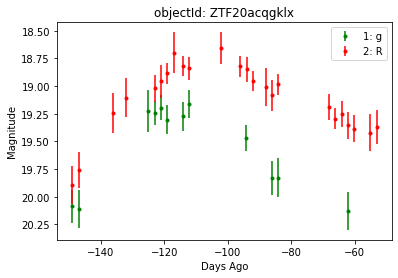

In [21]:
# make the plot
pgb.figures.plot_lightcurve(lc_df, objectId=objectId)
# this function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

---

### Cone Search

To perform a cone search, we query for object histories and then check whether they are within the cone. 
`pgb.bigquery.cone_search()` is a convenience wrapper for this.

First we set the search parameters.

In [22]:
center = coord.SkyCoord(76.91, 6.02, frame='icrs', unit='deg')
radius = coord.Angle(2, unit=u.deg)

columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'DIASource' table
# pgb.bigquery.get_table_info('DIASource')
dry_run = False

# we'll restrict to a handful of objects to reduce runtime, but this is optional
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

`cone_search()` has similar options to `query_objects()`:

In [23]:
# Option 1: Get a single df of all objects in the cone

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           dry_run=dry_run
                                           )
objects_in_cone.sample(5)

magpsf  fid  ...  sigmapsf         ra
objectId     candid                               ...                     
ZTF20acqgklx 1431341885215015008  19.107777    2  ...  0.176311  76.633692
             1442282165215015017  18.957773    2  ...  0.146518  76.633643
             1440322515215015022  19.242628    1  ...  0.108532  76.633675
             1501265425215015012  19.355988    2  ...  0.124827  76.633697
ZTF18aczuwfe 1501265423415015001  20.191540    2  ...  0.173003  77.496681

[5 rows x 6 columns]

In [24]:
# Option 2: Get a single json string of all objects in the cone
format = 'json'

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           dry_run=dry_run
                                           )
objects_in_cone

'{"objectId":{"0":"ZTF20acqgklx","1":"ZTF20acqgklx","2":"ZTF20acqgklx","3":"ZTF20acqgklx","4":"ZTF20acqgklx","5":"ZTF20acqgklx","6":"ZTF20acqgklx","7":"ZTF20acqgklx","8":"ZTF20acqgklx","9":"ZTF20acqgklx","10":"ZTF20acqgklx","11":"ZTF20acqgklx","12":"ZTF20acqgklx","13":"ZTF20acqgklx","14":"ZTF20acqgklx","15":"ZTF20acqgklx","16":"ZTF20acqgklx","17":"ZTF20acqgklx","18":"ZTF20acqgklx","19":"ZTF20acqgklx","20":"ZTF20acqgklx","21":"ZTF20acqgklx","22":"ZTF20acqgklx","23":"ZTF20acqgklx","24":"ZTF20acqgklx","25":"ZTF20acqgklx","26":"ZTF20acqgklx","27":"ZTF20acqgklx","28":"ZTF20acqgklx","29":"ZTF20acqgklx","30":"ZTF20acqgklx","31":"ZTF20acqgklx","32":"ZTF20acqgklx","33":"ZTF20acqgklx","34":"ZTF20acqgklx","35":"ZTF20acqgklx","36":"ZTF18aczuwfe","37":"ZTF18aczuwfe","38":"ZTF18aczuwfe","39":"ZTF18aczuwfe","40":"ZTF18aczuwfe","41":"ZTF18aczuwfe","42":"ZTF18aczuwfe","43":"ZTF18aczuwfe","44":"ZTF18aczuwfe","45":"ZTF18aczuwfe","46":"ZTF18aczuwfe","47":"ZTF18aczuwfe","48":"ZTF18aczuwfe","49":"ZTF18aczuw

In [25]:
# Option 3: Get a generator that yields dfs of individual objects in the cone
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(f'objectId: {obj.objectId}')  # objectId in metadata
    print(obj.head())

objectId: ZTF20acqgklx
                        magpsf  fid  ...  sigmapsf         ra
candid                               ...                     
1414351235215015023  19.898302    2  ...  0.171336  76.633736
1414365935215015038  20.088041    1  ...  0.152007  76.633646
1416400905215015017  19.761951    2  ...  0.163898  76.633719
1416427635215015028  20.111706    1  ...  0.172291  76.633691
1427289515215015014  19.247551    2  ...  0.180399  76.633629

[5 rows x 6 columns]
objectId: ZTF18aczuwfe
                        magpsf  fid  ...  sigmapsf         ra
candid                               ...                     
1440303993415015003  19.807590    2  ...  0.159926  77.496741
1440322513415015004  19.819330    1  ...  0.127621  77.496732
1442328323415015002  19.782700    1  ...  0.172808  77.496730
1444285643415015001  19.927372    2  ...  0.209740  77.496826
1449226053415015000  19.965925    2  ...  0.170471  77.496774

[5 rows x 6 columns]


In [26]:
# Get a generator that yields a json string of individual objects in the cone
format = 'json'
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(obj)

{"candid":{"0":1440303993415015003,"1":1440322513415015004,"2":1442328323415015002,"3":1444285643415015001,"4":1449226053415015000,"5":1451204593415015000,"6":1467211213415015002,"7":1469258283415015005,"8":1477168703415015002,"9":1477214243415015002,"10":1479193393415015001,"11":1479213073415015001,"12":1497147413415015000,"13":1497208623415015000,"14":1499171573415015000,"15":1499283323415015000,"16":1501265423415015001,"17":1503183253415015010,"18":1503208143415015003,"19":1510148923415015004,"20":1510206363415015002},"magpsf":{"0":19.8075904846,"1":19.8193302155,"2":19.782699585,"3":19.9273719788,"4":19.9659252167,"5":20.0367927551,"6":19.8974628448,"7":20.287065506,"8":19.468252182,"9":19.980096817,"10":19.7932052612,"11":19.8938179016,"12":19.7973613739,"13":19.8168411255,"14":20.1171741486,"15":19.8918972015,"16":20.1915397644,"17":20.3401679993,"18":19.9926147461,"19":20.0997200012,"20":19.8034667969},"fid":{"0":2,"1":1,"2":1,"3":2,"4":2,"5":2,"6":2,"7":2,"8":2,"9":1,"10":1,"11

---

### Direct access: Google Cloud SDK

The previous sections demonstrated convenience wrappers for querying with `google.cloud.bigquery`. Here we demonstrate using these tools directly with some basic examples. View `pgb_utils` source code for more examples.

Links to more information:
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [`google.cloud.bigquery` docs](https://googleapis.dev/python/bigquery/latest/index.html)

Query setup:

In [27]:
# Create a BigQuery Client to handle the connections
bq_client = bigquery.Client(project=my_project_id)

In [28]:
# Write the standard SQL query statement

# pgb.bigquery.get_dataset_table_names()  # view available tables
# pgb.bigquery.get_table_info('<table>')  # view available column names

# construct the full table name
table = 'salt2'
dataset = 'ztf_alerts'
full_table_name = f'{pgb_project_id}.{dataset}.{table}'

# construct the query
query = (
    f'SELECT objectId, candid, t0, x0, x1, c, chisq, ndof '
    f'FROM `{full_table_name}` '
    f'WHERE ndof>0 and chisq/ndof<2 '
)

# note: if you want to query object histories you can get the
# query statement using `pgb.bigquery.object_history_sql_statement()`

In [29]:
# Let's create a function to execute a "dry run"
# and tell us how much data will be processed.
# This is essentially `pgb.bigquery.dry_run()`
def dry_run(query):
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    query_job = bq_client.query(query, job_config=job_config)
    nbytes, TiB = query_job.total_bytes_processed, 2**40
    pTiB = nbytes/TiB*100  # nbytes as a percent of 1 TiB
    print(f'\nQuery statement:')
    print(f'\n"{query}"\n')
    print(f'will process {nbytes} bytes of data.')
    print(f'({pTiB:.3}% of your 1 TiB Free Tier monthly allotment.)')

In [30]:
# Find out how much data will be processed
dry_run(query)


Query statement:

"SELECT objectId, candid, t0, x0, x1, c, chisq, ndof FROM `ardent-cycling-243415.ztf_alerts.salt2` WHERE ndof>0 and chisq/ndof<2 "

will process 95410 bytes of data.
(8.68e-06% of your 1 TiB Free Tier monthly allotment.)


Query:

In [31]:
# Make the API request
query_job = bq_client.query(query)
# Beware: the results may contain duplicate entries

Format and view results:

t0        x0  ...      chisq  ndof
objectId     candid                                       ...                 
ZTF17aaaseus 1563186680815015012  59306.000000  0.000234  ...   3.695731     4
ZTF18aaavffc 1563205932415015020  59292.157232  0.000710  ...  13.447890    15
             1563239942415015011  59293.457096  0.000702  ...  29.502025    16
ZTF18aahfssj 1563205935915015019  59295.293222  0.000487  ...  13.664595    12
             1563239945915015015  59297.344906  0.000472  ...  21.455810    13

[5 rows x 6 columns]

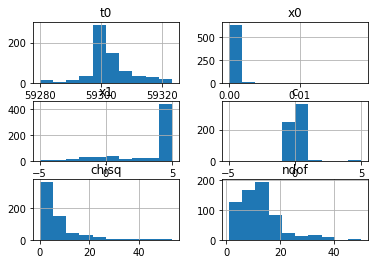

In [32]:
# Option 1: dump results to a pandas.DataFrame
df = query_job.to_dataframe()

# some things you might want to do with it
df = df.drop_duplicates()
df = df.set_index(['objectId','candid']).sort_index()

df.hist()
df.head()

In [33]:
# Option 2: parse results row by row
for r, row in enumerate(query_job):
    
    # row values can be accessed by field name or index
    print(f"objectId={row[0]}, t0={row['t0']}")
    
    if r>5: break

objectId=ZTF21aactwbe, t0=59280.00034567633
objectId=ZTF18acbzvvz, t0=59299.999999925276
objectId=ZTF18acwyjst, t0=59303.99999999153
objectId=ZTF18aahfssj, t0=59295.293222155975
objectId=ZTF18aamtcmw, t0=59299.999999999156
objectId=ZTF21aarwlht, t0=59316.999999061976
objectId=ZTF19aangwaa, t0=59301.999999855485


---

## 3b) Command-line tool `bq`

All commands in this section are executed using the `run` function we created earlier to run commands on the command-line.

`bq`'s default dialect is legacy SQL. Here we use standard SQL by passing `--use_legacy_sql=false`.
<!-- (see [change to standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Quickstart using the bq command-line tool](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-command-line)
- [Reference of all `bq` commands and flags](https://cloud.google.com/bigquery/docs/reference/bq-cli-reference)
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)

In [34]:
# Get help
run('bq help query')

>> bq help query
Python script for interacting with BigQuery.


USAGE: bq.py [--global_flags] <command> [--command_flags] [args]


query                      Execute a query.

                           Query should be specified on command line, or passed
                           on stdin.

                           Examples:
                           bq query 'select count(*) from
                           publicdata:samples.shakespeare'
                           echo 'select count(*) from
                           publicdata:samples.shakespeare' | bq query

                           Usage:
                           query [<sql_query>]

                           Flags for query:

                             /tools/google-cloud-sdk/platform/bq/bq.py:
                               --[no]allow_large_results: Enables larger
                                 destination table sizes for legacy SQL queries.
                               --[no]append_table: When a destination tabl

In [35]:
# view the schema of a table
run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.DIASource')
# run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.alerts')

# Note: The first time you make a call with `bq` you will ask you to 
# initialize a .bigqueryrc configuration file. Follow the directions.

>> bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.DIASource

Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
[
  {
    "#": 1, 
    "friendlyName": "Budget", 
    "projectId": "budget-242622"
  }, 
  {
    "#": 2, 
    "friendlyName": "Kafka to BigQuery", 
    "projectId": "kafka-to-bigquery"
  }, 
  {
    "#": 3, 
    "friendlyName": "My First Project", 
    "projectId": "smiling-timing-239918"
  }, 
  {
    "#": 4, 
    "friendlyName": "Pitt-Broker", 
    "projectId": "pitt-broker"
  }, 
  {
    "#": 5, 
    "friendlyName": "pitt-google-broker-prototype", 
    "projectId": "ardent-cycling-243415"
  }
]
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a

In [36]:
# Query: dry run

# first we do a dry_run by including the flag --dry_run
bq_query = """bq query \
--dry_run \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)
# Note: to execute this directly in the command-line, enter everything 
# contained within the triple quotes.

>> bq query --dry_run --use_legacy_sql=false 'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'

Query successfully validated. Assuming the tables are not modified, running this query will process 95410 bytes of data.



In [37]:
# Query

bq_query = """bq query \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)

>> bq query --use_legacy_sql=false 'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'

Waiting on bqjob_r7045e22e44729044_00000178ca3977a3_1 ... (0s) Current status: DONE   
+--------------+---------------------+--------------------+-----------------------+---------------------+----------------------+--------------------+------+
|   objectId   |       candid        |         t0         |          x0           |         x1          |          c           |       chisq        | ndof |
+--------------+---------------------+--------------------+-----------------------+---------------------+----------------------+--------------------+------+
| ZTF21aactwbe | 1563194074315015020 |  59280.00034567633 |  1.070378129098851E-4 |  3.3418872100970383 |   0.6608066699178483 | 3.1247765139313963 |    3 |
| ZTF18acbzvvz | 1563202543315015006 | 59299.999999925276 | 1.9213943360541654E-4 |   4.999

---

# 4) Files in Cloud Storage

We store the alert packets as Avro files named as "{objectId}.{candid}.{ztf_topic}.avro"

- Pricing
    - [Cloud Storage pricing](https://cloud.google.com/storage/pricing)
        - [Free Tier](https://cloud.google.com/storage/pricing#cloud-storage-always-free) includes >=5000 operations per month, but is limited to US regions(*). Standard operations are $0.004-$0.05 per 10,000 operations (depending on type).

(*) This will depend on where Colab is running, which is non-configurable.

## 4a) Python

- [Python Client documentation](https://googleapis.dev/python/storage/latest/client.html) (Google Cloud SDK)

### Download files

Download alerts for a given `objectId`

In [50]:
objectId = 'ZTF17aaackje'
bucket_name = f'{pgb_project_id}_ztf_alert_avros'

# Create a client and request a list of files
storage_client = storage.Client(my_project_id)
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=objectId)

In [51]:
# download the files
for blob in blobs:
    local_path = f'{colabpath_noesc}/{blob.name}'
    blob.download_to_filename(local_path)
    print(f'Downloaded {local_path}')

Downloaded /content/drive/MyDrive/Colab Notebooks/PGB_tutorial/ZTF17aaackje.1563161493315010012.ztf_20210413_programid1.avro
Downloaded /content/drive/MyDrive/Colab Notebooks/PGB_tutorial/ZTF17aaackje.1563186683315010018.ztf_20210413_programid1.avro


### Plot cutouts and lightcurves

The functions in this section were adapted from https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb.


Open a file
(see the previous section to download files)

In [52]:
paths = Path(colabpath_noesc).glob('*.avro')
for path in paths:
    with open(path, 'rb') as fin:
        alert_list = [r for r in fastavro.reader(fin)]
    break
alert_dict = alert_list[0]  # extract the single alert packet

print(alert_dict.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


Plot cutouts

INFO: Auto-setting vmin to  2.258e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.591e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.351e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.794e+02 [aplpy.core]


INFO: Auto-setting vmin to -1.312e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.068e+01 [aplpy.core]


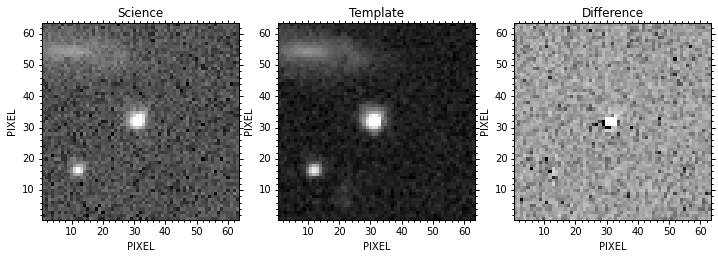

In [53]:
pgb.figures.plot_cutouts(alert_dict)

Cast to a dataframe and plot lightcurves

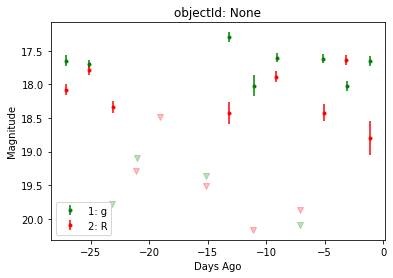

In [54]:
dflc = pgb.utils.alert_dict_to_dataframe(alert_dict)
pgb.figures.plot_lightcurve(dflc)

Plot everything together

INFO: Auto-setting vmin to  2.258e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.591e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.351e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.794e+02 [aplpy.core]


INFO: Auto-setting vmin to -1.312e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.068e+01 [aplpy.core]


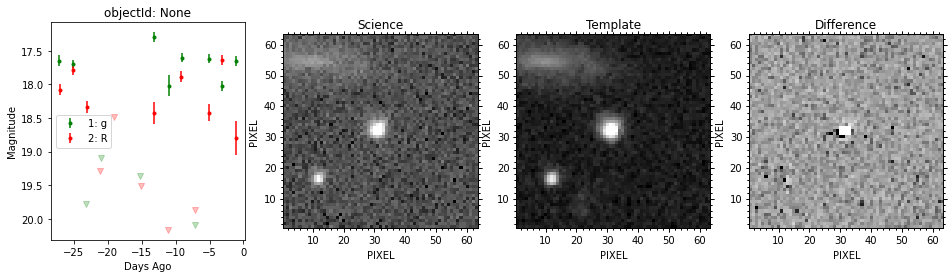

In [55]:
pgb.figures.plot_lightcurve_cutouts(alert_dict)

## 4b) Command-line tool `gsutil`

- [Quickstart: Using the gsutil tool](https://cloud.google.com/storage/docs/quickstart-gsutil)
- [`gsutil cp` - Copy files and objects](https://cloud.google.com/storage/docs/gsutil/commands/cp)

In [56]:
# Get help
# run('gsutil help')
run('gsutil help cp')

>> gsutil help cp
NAME
  cp - Copy files and objects


SYNOPSIS

  gsutil cp [OPTION]... src_url dst_url
  gsutil cp [OPTION]... src_url... dst_url
  gsutil cp [OPTION]... -I dst_url



DESCRIPTION
  The ``gsutil cp`` command allows you to copy data between your local file
  system and the cloud, within the cloud, and between
  cloud storage providers. For example, to upload all text files from the
  local directory to a bucket, you can run:

    gsutil cp *.txt gs://my-bucket

  You can also download text files from a bucket:

    gsutil cp gs://my-bucket/*.txt .

  Use the ``-r`` option to copy an entire directory tree.
  For example, to upload the directory tree ``dir``:

    gsutil cp -r dir gs://my-bucket

  If you have a large number of files to transfer, you can perform a parallel
  multi-threaded/multi-processing copy using the
  top-level gsutil ``-m`` option (see "gsutil help options"):

    gsutil -m cp -r dir gs://my-bucket

  You can use the ``-I`` option with ``stdin`` to

Download a single file

In [58]:
run(f'gsutil cp gs://ardent-cycling-243415_ztf_alert_avros/ZTF17aaackje.1563161493315010012.ztf_20210413_programid1.avro {colabpath}/.')

>> gsutil cp gs://ardent-cycling-243415_ztf_alert_avros/ZTF17aaackje.1563161493315010012.ztf_20210413_programid1.avro /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/.
Copying gs://ardent-cycling-243415_ztf_alert_avros/ZTF17aaackje.1563161493315010012.ztf_20210413_programid1.avro...
/ [1 files][ 69.6 KiB/ 69.6 KiB]                                                
Operation completed over 1 objects/69.6 KiB.                                     



---

# 5) Apache Beam data pipelines

[Apache Beam](https://beam.apache.org/) is an SDK that facilitates writing and executing data pipelines. The [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/) is very useful! 

- In this section of the tutorial, we will demonstrate and describe batch-mode Beam pipelines, and provide working examples that read from our BigQuery database, and execute user-defined functions (with template functions that you can play with), and write results to a text file.
- We will develop and test them within Colab. To run large jobs, the pipelines can be executed in Dataflow (Google Cloud), on AWS, etc. See "Note on environments" below.
- You can plug these same pipelines into the live alert streams to process data in real-time. See the "Note on streaming" below.

_Note on environments_: We will execute pipelines directly in Colab, but the same pipelines can be executed on a local machine or various distributed systems using different "runners". 
For example, see 
[Apache Flink](https://beam.apache.org/documentation/runners/flink/), 
[Apache Spark](https://beam.apache.org/documentation/runners/spark/), 
[Google Dataflow](https://beam.apache.org/documentation/runners/dataflow/), and
[DirectRunner](https://beam.apache.org/documentation/runners/direct/) (the last being the default, which we use below).
The user sets a few configurations and the runner does the work of executing the pipeline, managing the required environments and resources (e.g., VM's) and distributing the work.

_Note on streaming_: The cores of these pipelines (the pipeline minus the input and output functions) can also be plugged directly into an input function that reads data from our Pub/Sub streams and then executes in streaming mode, writing to a sink that accepts streaming data, like Pub/Sub or BigQuery. In this tutorial we will make some comments regarding streaming pipelines where applicable, but the details are left for a future tutorial. In the meantime, please contact us with questions.

---

## 5a) A demo example

To demonstrate the basic steps of an Apache Beam pipeline, we'll create one that counts the words in Shakespeare's King Lear and then filters for low-frequency words.
Adapted from [this notebook](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-py.ipynb).

Streaming note: [here is an example](https://beam.apache.org/documentation/sdks/python-streaming/) that modifies a similar word-counting pipeline for streaming input via Pub/Sub. Note that "windowing" is only required because this example aggregates elements in the pipeline (by counting the frequency of each word). This is not necessary in order to, for example, process each lightcurve.

In [59]:
import re

Setup: create some paths and download a copy of King Lear

In [60]:
kinglearpath = f'{colabpath}/kinglear'
kinglearpath_noesc = f'{colabpath_noesc}/kinglear'
run(f'mkdir -p {kinglearpath}')
run(f'mkdir -p {kinglearpath}/outputs')

# download the text file
run(f'gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt {kinglearpath}/')

# Colab Hint: Click the "Files" icon on the left to view a file browser.

>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/kinglear

>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/kinglear/outputs

>> gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/kinglear/
Copying gs://dataflow-samples/shakespeare/kinglear.txt...
/ [1 files][153.6 KiB/153.6 KiB]                                                
Operation completed over 1 objects/153.6 KiB.                                    



Define and run the pipeline.

This example will give you an idea about what it possible by demonstrating the use of several different Apache Beam functions that operate on the data in various ways.
However, don't worry about the details here.
Steps labeled 1, 2, and 3 in the code are described further in the following subsection. Working examples that connect to our data sources will follow.

Note that some [operators are overloaded](https://stackoverflow.com/questions/43796046/explain-apache-beam-python-syntax):
- `|` means `apply`
- `>>` allows you to name the step with the preceeding string. It is optional. We use it here to improve readability. Various UIs like Dataflow use it in their displays.

In [61]:
input_pattern = f'{kinglearpath_noesc}/*'
outputs_prefix = f'{kinglearpath_noesc}/outputs/part'

# 0. Instantiate a pipeline object
with beam.Pipeline() as pipeline:
  (
    # 1. Start the pipeline by piping it to a "read" function
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(input_pattern)

    # 2. PROCESS THE DATA.
    #    These `lambda` functions are simple examples of user-defined functions 
    #    applied to the output of the previous transformation in various ways.
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Filter for counts < 10' >> beam.Filter(lambda x: x[1]<10)

    # 3. Format and output the results
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

You have just run an Apache Beam data pipeline! Let's look at the first 20 results. Beware, there are no ordering guarantees.

In [62]:
outputs_prefix_esc = f'{kinglearpath}/outputs/part'
run('head -n 20 {}-00000-of-*'.format(outputs_prefix_esc))

>> head -n 20 /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/kinglear/outputs/part-00000-of-*
('DRAMATIS', 1)
('PERSONAE', 1)
('Britain', 2)
('DUKE', 3)
('BURGUNDY', 8)
('EARL', 2)
('bastard', 7)
('CURAN', 6)
('courtier', 1)
('tenant', 3)
('steward', 2)
('employed', 1)
('attendant', 1)
('Herald', 6)
('Servants', 9)
('First', 7)
('Second', 4)
('Third', 4)
('Knights', 2)
("Lear's", 4)



Final note: Here we have simply chained the pipeline steps together, but the output of each transformation is an immutable collection that we can assign to a variable and pipe in to multiple transforms, as in this code fragment:

```python
      king_lear = (
          pipeline | 'Read lines' >> 
          beam.io.ReadFromText(input_pattern)
      )
      word_counts = (
          king_lear | 'Count words' >>
          <... count words ...>
      )
      sentence_counts = (
          king_lear | 'Count sentences' >>
          <... count sentences ...>
      )
```

---

## 5b) Descriptions

Here we describe 3 basic steps of Beam pipelines, and their related functions, in a way that is specific to the "Pitt-Google working examples" that follow. These general steps are labeled in the code of the demo example above.

1. __Read data__

Here is a table of Beam's [Built-in I/O Transforms](https://beam.apache.org/documentation/io/built-in/). We will use one to read data from BigQuery.

`ReadFromBigQuery()` ([docs](https://beam.apache.org/releases/pydoc/2.25.0/apache_beam.io.gcp.bigquery.html#apache_beam.io.gcp.bigquery.ReadFromBigQuery)):

Output: 
- Elements are `google.cloud.bigquery` query rows, which we discussed in the "BigQuery Database" section. 
    - In our example pipelines below, we will cast these to DataFrames using a class in `pgb_utils.beam`, which is a simple wrapper for the function in `pgb_utils.bigquery` that does the type casting.

Parameter options (see docs for complete list):
- `query`: to read in the results of a SQL query, pass in the query as a string. See the "BigQuery Database" section of this tutorial for some examples.
- `table`: to read in an entire table, pass in the full table name as `'PROJECT:DATASET.TABLE'`. See the "BigQuery Database" section of this tutorial for options.
- `gcs_location`: the table or query results will be extracted and written to temporary Avro files to be processed by the pipeline (this happens in the background). Colab does not allow users to write these (often large) files to its system, so we use this parameter to specify a Google Cloud Storage location instead. Pitt-Google Broker is providing a bucket for this purpose _for the duration of the workshop_. It is set in the examples' configs below.
- `use_standard_sql`: `True` to use BigQuery's standard SQL dialect. (default `False`)
- `validate`: `True` to perform some checks prior to pipeline execution. `False` (default) to skip them.

Streaming note: use `ReadFromPubSub()` ([docs](https://beam.apache.org/releases/pydoc/2.25.0/apache_beam.io.gcp.pubsub.html#apache_beam.io.gcp.pubsub.ReadFromPubSub))

2. __Process the data__

We will use of 2 of the available methods, which covers many use cases. Here, we describe them. In the next section, we will provide working examples that you can use as templates. See the demo example above and the [Beam programming guide](https://beam.apache.org/documentation/programming-guide/) for options beyond these two.

- [`beam.Filter()` method](https://beam.apache.org/documentation/transforms/python/elementwise/filter/): 
    - A. Define your `my_filter()` function. It should:    
        - accept a single object from the collection defined by the previous step in the pipeline (e.g., a lightcurve dataframe)
        - return `True` or `False`, where `False` means the object will be dropped
    - B. Apply it using `beam.Filter(my_filter)`

- [`beam.ParDo()` method](https://beam.apache.org/documentation/transforms/python/elementwise/pardo/) for generic parallel processing:
    - A. Define your processing function. You must call it `process()`. It should:
        - accept a single object from the input collection
        - return a list of one or more objects (all of the same type) that will become elements in the resulting output collection
    - B. Wrap your function in a class, `my_processing()` (call it whatever you'd like). This should be a child class of `beam.DoFn`.
    - C. Apply it to the input collection using `beam.ParDo(my_processing())`

Some things to keep in mind:
- The output from each step in the pipeline is an imutable _collection_ of objects.
    - When we chain our pipeline steps, we are piping the output collection from a given function to the input of the function that follows it. Alternately, we could assign each output to a variable, and then explicitely pipe it in to one or more of any functions that follow it. See the final note in the demo example above.
- User-defined functions should accept and operate on a _single_ object (for example, the lightcurve or history associated with a unique `objectId`). 
    - Note that whether the pipeline is operating in batch or streaming mode makes no difference to user-defined functions.



3. __Write the results__

Here is a table of Beam's [Built-in I/O Transforms](https://beam.apache.org/documentation/io/built-in/). There are many. Your favorite option is likely to be supported. We will use one to simply write results to a file.

`beam.io.WriteToText()` ([docs](https://beam.apache.org/releases/pydoc/2.25.0/apache_beam.io.textio.html#apache_beam.io.textio.WriteToText)):

Input:
- we can pipe in inputs of many different types (though the elements in a single input collection must all be of the same type).

Parameter options (see docs for complete list):
- `file_path_prefix`: output files will be written to a path beginning with this prefix, followed by a shard identifier.

---

## 5c) Pitt-Google working examples

In these examples, we will query the database for object histories and cast them to DataFrames, apply a filter and a processing function, and write the results to a text file.

Here's a preview of the pipeline we will create and run.

Pipeline:

```python
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read from BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        | 'Type cast to DataFrame' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        | 'Is nearby known SS object' >> beam.Filter(nearby_ssobject)
        | 'Calculate mean magnitudes' >> beam.ParDo(calc_mean_mags())
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )
```

With comments:

```python
# 0. Instantiate a pipeline object
with beam.Pipeline() as pipeline:
    (

# 1. Start the pipeline by piping it to a "read" function. Then format the incoming data as a DataFrame.
        pipeline
        | 'Read from BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        | 'Type cast to DataFrame' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        
# 2. PROCESS the data with USER-DEFINED FUNCTIONS
        # Apply a Filter
        | 'Is nearby known SS object' >> beam.Filter(nearby_ssobject)
        # Apply a processing function
        | 'Calculate mean magnitudes' >> beam.ParDo(calc_mean_mags())
        
# 3. Output the results
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )
```

First, let's define our user-defined functions: a filter and a processing function.
Both will take as input `lc_df`, a single object's lightcurve (or history) DataFrame.
_The functions will work as-is, or you can use them as templates to create your own._

_Colab Hint_: Right-click on one of the code cells with a function definition and select "Copy to scratch cell". Use the new scratch cell to change the function and experiment with the pipeline.

In [63]:
# Filter for likely solar system objects

def nearby_ssobject(lc_df):
    """Keep only objects that are within 5" of a known solar system object.
    To be called with `beam.Filter(nearby_ssobject)`.
    """

    ssdistnr = lc_df['ssdistnr'].mean()
    ssobject_is_near = (ssdistnr > 0) and (ssdistnr < 5)

    return ssobject_is_near
    # generally: return a bool where `True` means we keep this df, else drop it

In [64]:
# Processing: Calculate and return the mean magnitude per passband

class calc_mean_mags(beam.DoFn):
    """Class that wraps our `process()` function to calculate mean magnitudes.
    To be called with `beam.ParDo(calc_mean_mags())`.
    """

    def process(self, lc_df):
        """Calculate mean magnitudes per passband."""

        meanmags = lc_df[['fid','magpsf']].groupby('fid').mean()

        # we will write this to a file, so let's format it nicely
        output = []
        for fid, row in meanmags.iterrows():
            output.append(f"{lc_df.objectId},{fid},{row['magpsf']}")

        return output
        # generally: return a list containing 0 or more elements (all of the same
        # type), each of which becomes an element in the step's output collection.

Now let's configure and run specific pipelines.

### Lightcurve pipeline

Set configs

See the "BigQuery Database" section for options to generate the query statement, or write your own SQL.

Use `pgb.bigquery.get_table_info('DIASource')` in a scratch cell to view options for column names.


In [65]:
# keyword args for `ReadFromBigQuery()`
columns = ['jd', 'fid', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000  # just to reduce runtime
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str
read_args = {
    'query': query, 
    'project': my_project_id,  
    'use_standard_sql': True, 
    'gcs_location': f'gs://{pgb_project_id}-workshop_beam_test',
    # courtesy location for temp files, available for the workshop duration
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/meanmags'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/meanmags'

Define and run the pipeline

In [66]:
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        | 'Type cast to DataFrame' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        | 'Is nearby known SS object' >> beam.Filter(nearby_ssobject)
        | 'Calculate mean magnitudes' >> beam.ParDo(calc_mean_mags())
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


Congratulations! You just ran an Apache Beam pipeline that fetches ZTF data, filters and processes it, and writes out the results!

Let's look at the first 10 results. Remember, there are no ordering guarantees.

In [67]:
run('head -n 10 {}-00000-of-*'.format(outputs_prefix))

>> head -n 10 /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/outputs/meanmags-00000-of-*
ZTF20acqutcd,1,19.93570327758789
ZTF20acyzuld,1,19.557735443115234
ZTF20acqmdab,1,20.059526443481445
ZTF20acvzgxs,1,18.449440002441406
ZTF20acvzwvf,1,17.4761905670166
ZTF20acynsfk,1,19.433037757873535
ZTF21aaoramd,2,19.061250686645508
ZTF21aaocoik,2,20.095518112182617
ZTF21aaoebaf,2,19.495492935180664
ZTF20acyydxb,2,18.74314308166504



### Cone Search pipeline

This pipeline for performing a cone search and processing the results is nearly identical to the lightcurve pipeline above. The differences are that here:
- we need the additional columns `ra` and `dec`
- we apply the convenience function `pgb.bigquery.object_is_in_cone()` as a filter on the results of `ReadFromBigQuery()`. We must pass a cone `center` and `radius` to the convenience function, so note the syntax below.

You may wish to improve the efficency by limiting the input data via a more specific SQL query statement.

Set configs

In [71]:
# cone search params
center = coord.SkyCoord(76.91, 6.02, frame='icrs', unit='deg')
radius = coord.Angle(2, unit=u.deg)

# some keyword args for `ReadFromBigQuery()`
columns = ['jd', 'fid', 'ra', 'dec', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 5000
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str
read_args = {
    'query': query, 
    'project': my_project_id,  
    'use_standard_sql': True, 
    'gcs_location': f'gs://{pgb_project_id}-workshop_beam_test',
    # courtesy location for temp files, available for the workshop duration
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/conesearch'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/conesearch'

Define and run the pipeline

In [72]:
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)

        # Extract the lightcurves into a DataFrame by applying a 
        # `ParDo` to a `pgb` helper function.
        | 'Extract Lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        
        # Apply the Filter
        | 'Cone search filter' >> beam.Filter(pgb.bigquery.object_is_in_cone, 
                                              center, 
                                              radius
                                              )

        # Apply the processing function
        | 'Calc mean mags' >> beam.ParDo(calc_mean_mags())
        
        # Write the results to a text file
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


In [73]:
# Sample the first 10 results, remember there are no ordering guarantees.
run('head -n 10 {}-00000-of-*'.format(outputs_prefix))

>> head -n 10 /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/outputs/conesearch-00000-of-*
ZTF20acxpnkl,1,19.60205841064453
ZTF18adfpejp,1,17.62468147277832
ZTF18abxbdrb,1,18.931528091430664
ZTF18abxbdrb,2,18.070329030354817
ZTF19abpnrtn,1,18.018795437282986
ZTF19abpnrtn,2,17.128609657287598



If you don't see any results, your query likely did not return any objects that fell within the cone. Try increasing the limit for `ReadFromBigQuery` or moving to a different position on the sky.